In [1]:
import scipy

In [2]:
scipy.__version__

'1.5.4'

In [3]:
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

# Torus

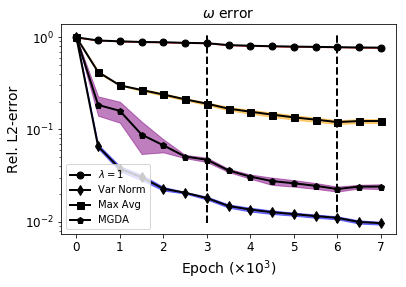

In [5]:
errs = []
for i,seed in enumerate(range(1,4)):
    _errs = []
    for j,method in enumerate([4,6,5,3]):
        app = "_eps1e-06" if method == 3 else ""
        data = sio.loadmat("evals/solve_vv/eval_s{}_l7_nl0.0_dms256_meth{}{}_surya_bc_nown_circle".format(seed,method,app))
        din = sio.loadmat("evals/init_err_torus.mat")
        try:
            et = data["train_w"][0]
            if len(et)==71:
                _errs.append(et[:][::5])
            else:
                _errs.append(np.insert(et[4:][::5], 0, din["err"][j][i]))
        except:
            et = data["w_train"][0]
            if len(et)==71:
                _errs.append(et[:][::5])
            else:
                _errs.append(np.insert(et[4:][::5], 0, din["err"][j][i]))
                
    errs.append(_errs)

mean = np.mean(errs, 0)
std  = np.std(errs, 0) 

ticks = ["-o", "-d", "-s", "-p", "-v", "-+"]
#label = ["STD", "Reg. STD", "Max Avg", "Optimal 1e-6", "Optimal 1e-8", "Vanilla"]
label = [r"$\lambda=1$", "Var Norm", "Max Avg", "MGDA"]
colors = ["red", "blue", "orange", "purple"]

plt.plot(np.arange(0.0,7.1,0.5),  mean[0].T, ticks[0], label=label[0], color="black", linewidth=2, markersize=7)
plt.plot(np.arange(0.0,7.1,0.5),  mean[1].T, ticks[1], label=label[1], color="black", linewidth=2, markersize=7)
plt.plot(np.arange(0.0,7.1,0.5),  mean[2].T, ticks[2], label=label[2], color="black", linewidth=2, markersize=7)
plt.plot(np.arange(0.0,7.1,0.5), mean[3].T, ticks[3], label=label[3], color="black", linewidth=2, markersize=7)

plt.fill_between(np.arange(0.0,7.1,0.5), mean[0]-std[0], mean[0]+std[0], color=colors[0], alpha=0.5)
plt.fill_between(np.arange(0.0,7.1,0.5), mean[1]-std[1], mean[1]+std[1], color=colors[1], alpha=0.5)
plt.fill_between(np.arange(0.0,7.1,0.5), mean[2]-std[2], mean[2]+std[2], color=colors[2], alpha=0.5)
plt.fill_between(np.arange(0.0,7.1,0.5), mean[3]-std[3], mean[3]+std[3], color=colors[3], alpha=0.5)

plt.vlines(3, np.min(mean), np.max(mean)+0.1, color="black", linestyle="dashed", linewidth=2)
plt.vlines(6, np.min(mean), np.max(mean)+0.1, color="black", linestyle="dashed", linewidth=2)
    
plt.title(r"$\omega$ error", fontsize=14)
plt.ylabel("Rel. L2-error", fontsize=14)
plt.xlabel(r"Epoch ($\times 10^3$)", fontsize=14)
plt.yscale("log")
plt.legend()

plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("/projects/ppm/sturm/images/solve_vv_error_evolution_circle_seeded.eps")

# Predict Snapshots

In [1]:
import os
import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../')

from pinnutils import *

In [2]:
def create_circular_mask(height, width, radius):
    center = (int(width/2), int(height/2))
    Y, X = np.meshgrid(np.arange(height), np.arange(width))
    dist = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist <= radius
    return mask

def collect_within(height,width,r):
    # collect masks for inner and outer circles
    m1 = create_circular_mask(height,width,r[0])
    m2 = create_circular_mask(height,width,r[1])
    
    # join masks and return indeces within torus
    return ~np.logical_or(m1, ~m2)

In [3]:
int_r = (11,34) # interior (not including boundary)
bc_ri = (10,11) # inner boundary
bc_ro = (34,35) # outer boundary
ini_r = (10,35) # initial condition

In [9]:
device = torch.device("cpu")

dms = 256

data = sio.loadmat("/projects/ppm/surya/spectral_simulations/meso_bacterial_turbulence_IFRK4_N{}_2pi_dt0p01_Tmax10.mat".format(dms))

cut_lb = 60
cut_ub = 132

N = 256; domain_size = 2.0*np.pi; h = (domain_size)/N;
x = [h*i for i in range(1,N+1)]; y = [h*i for i in range(1,N+1)]
dx = x[1] - x[0]; dy = y[1] - y[0];

x = x[cut_lb:cut_ub]
y = y[cut_lb:cut_ub]

interpol = 50

ts = 420
te = ts + interpol

u = np.transpose(data["store_data_u"], (2,0,1))[ts:te, cut_lb:cut_ub, cut_lb:cut_ub]
v = np.transpose(data["store_data_v"], (2,0,1))[ts:te, cut_lb:cut_ub, cut_lb:cut_ub]
w = np.transpose(data["store_data"], (2,0,1))[ts:te, cut_lb:cut_ub, cut_lb:cut_ub]

dt    = 0.01
t_min = ts * dt
t_max = te * dt

t  = np.arange(t_min, t_max, dt)
tt = np.zeros(u.shape)
for i in range(u.shape[0]):
    tt[i,:,:] = np.full(u.shape[1:], t[i])
    
xx  = np.zeros(u.shape)
yy  = np.zeros(u.shape)

N = dms; domain_size = 2.0*np.pi; h = (domain_size)/N;
dom = [h*i for i in range(1,N+1)]

#dom = np.linspace(0, 2*np.pi, dms)
#print(len(dom))

dom_x = dom[cut_lb:cut_ub]
dom_y = dom[cut_lb:cut_ub]
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        xx[i,:,j] = dom_x
        yy[i,j,:] = dom_y

def ca(arr,r):
    # get *circle array* data by applying masks for radii r
    # and reshape into column vector
    return arr[collect_within(72, 72, r)][:,None]

# full input coordinates for eval
Xf     = np.concatenate([xx.reshape(-1)[:,None], yy.reshape(-1)[:,None], tt.reshape(-1)[:,None]], 1)
X_full = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)

un = u
vn = v

# radii for intirior, boundary (inner,outer) and initial conditions
int_r = (11,34) # interior (not including boundary)
bc_ri = (10,11) # inner boundary
bc_ro = (34,35) # outer boundary
ini_r = (10,35) # initial condition

# initial condition
X0 = np.concatenate([ca(xx[0], ini_r), ca(yy[0], ini_r), ca(tt[0], ini_r)], 1)
Y0 = np.concatenate([ca(un[0], ini_r), ca(vn[0], ini_r)], 1)

# interior and boundary points
# setup training data by iterating over time slices and extracting circles
X = None
XB = None
YB = None
for i in range(len(t)):
    # interior points
    xi = np.concatenate([ca(xx[i], int_r), ca(yy[i], int_r), ca(tt[i], int_r)], 1)
    
    # boundary points (inner/outer)
    xbi = np.concatenate([ca(xx[i], bc_ri), ca(yy[i], bc_ri), ca(tt[i], bc_ri)], 1)
    xbo = np.concatenate([ca(xx[i], bc_ro), ca(yy[i], bc_ro), ca(tt[i], bc_ro)], 1)
    
    xb = np.concatenate([xbi,xbo], 0)
    
    ybi = np.concatenate([ca(un[i], bc_ri), ca(vn[i], bc_ri)], 1)
    ybo = np.concatenate([ca(un[i], bc_ro), ca(vn[i], bc_ro)], 1)
    
    yb = np.concatenate([ybi,ybo], 0)
    
    if X is None:
        X  = xi
        XB = xb
        YB = yb
    else:
        # stack together over all time slices
        X  = np.concatenate([X, xi], 0)
        XB = np.concatenate([XB, xb], 0)
        YB = np.concatenate([YB, yb], 0)

X_train = torch.tensor(X, dtype=torch.float32)
print("#samples", X_train.shape[0])

# setup boundary and 
XB_train = torch.tensor(XB, dtype=torch.float32, device=device)
YB_train = torch.tensor(YB, dtype=torch.float32, device=device)

X0_train = torch.tensor(X0, dtype=torch.float32, device=device)
Y0_train = torch.tensor(Y0, dtype=torch.float32, device=device)

TD = np.concatenate([X, XB, X0], 0)

# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)
X_std  = torch.tensor(np.std(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)

def get_model_name(seed,ll,suff,nl,dms,method,tol,app):
    model_name = ""
    if method == 3:
        model_name = "solve_vv/model_active_s{}_l{}_n100_{}_nl{}_sol_dms{}_act1_meth{}_eps{}_surya_bc_nown_circle".format(seed,ll,suff,nl,dms,method,tol)
    else:
        model_name = "solve_vv/model_active_s{}_l{}_n100_{}_nl{}_sol_dms{}_act1_meth{}_surya_bc_nown_circle".format(seed,ll,suff,nl,dms,method)
    
    return model_name

err = []
for method in [(4,1e-8),(6,1e-8),(5,1e-8),(3,1e-6),(3,1e-7),(3,1e-8)]:
    _err = []
    for ep in range(100,7001,100):
        print(method, ep, end="\r")
        suff       = "ep"+str(ep) if ep < 7000 else "full"
        model_name = get_model_name(2,7,suff,0.0,256,method[0],method[1],"")

        layers = [3] + 7*[100] + [2]
        net = PINNNoWN(layers, mean=X_mean, std=X_std, seed=2, activation=Sin()).to(device)

        checkpoint = torch.load("models/" + model_name + ".pth", map_location=device)
        net.load_state_dict(checkpoint["model"])

        # write out results on full interpolation data
        X_in = torch.tensor(Xf, dtype=torch.float32, device=device, requires_grad=True)
        out_full = net(X_in)

        uhf, vhf, whf = compute_vort_param(out_full, X_in)

        uh = uhf.reshape(un.shape)
        vh = vhf.reshape(un.shape)
        wh = whf.reshape(un.shape)

        mask = collect_within(72,72,ini_r)

        werr = np.linalg.norm(wh[:,mask].reshape(-1)-w[:,mask].reshape(-1))/np.linalg.norm(w[:,mask].reshape(-1))
        
        _err.append(werr)
    err.append(_err)

#samples 162400


KeyboardInterrupt: 

In [10]:
def pred_solution():
    center_plot = dom_x[int(len(dom_x)/2)]
    width_c1 = (dom_x[int(len(dom_x)/2)+10]-dom_x[int(len(dom_x)/2)-10])/2
    width_c2 = (dom_x[int(len(dom_x)/2)+35]-dom_x[int(len(dom_x)/2)-35])/2

    # load model
    layers = [3] + 7*[100] + [2]
    net = PINNNoWN(layers, mean=X_mean, std=X_std, seed=2, activation=Sin()).to(device)

    model_name = get_model_name(2,7,suff,0.0,256,method,tol,"")
    checkpoint = torch.load("models/" + model_name + ".pth", map_location=device)

    net.load_state_dict(checkpoint["model"])

    # write out results on full interpolation data
    X_in = torch.tensor(Xf, dtype=torch.float32, device=device, requires_grad=True)
    out_full = net(X_in)

    uhf, vhf, whf = compute_vort_param(out_full, X_in)

    uh = uhf.reshape(un.shape)
    vh = vhf.reshape(un.shape)
    wh = whf.reshape(un.shape)

    mask = collect_within(72,72,ini_r)
    
    return uh,vh,wh,mask

method = 6
tol    = 1e-6
suff   = "full"

0 4
1 6
2 5
3 3


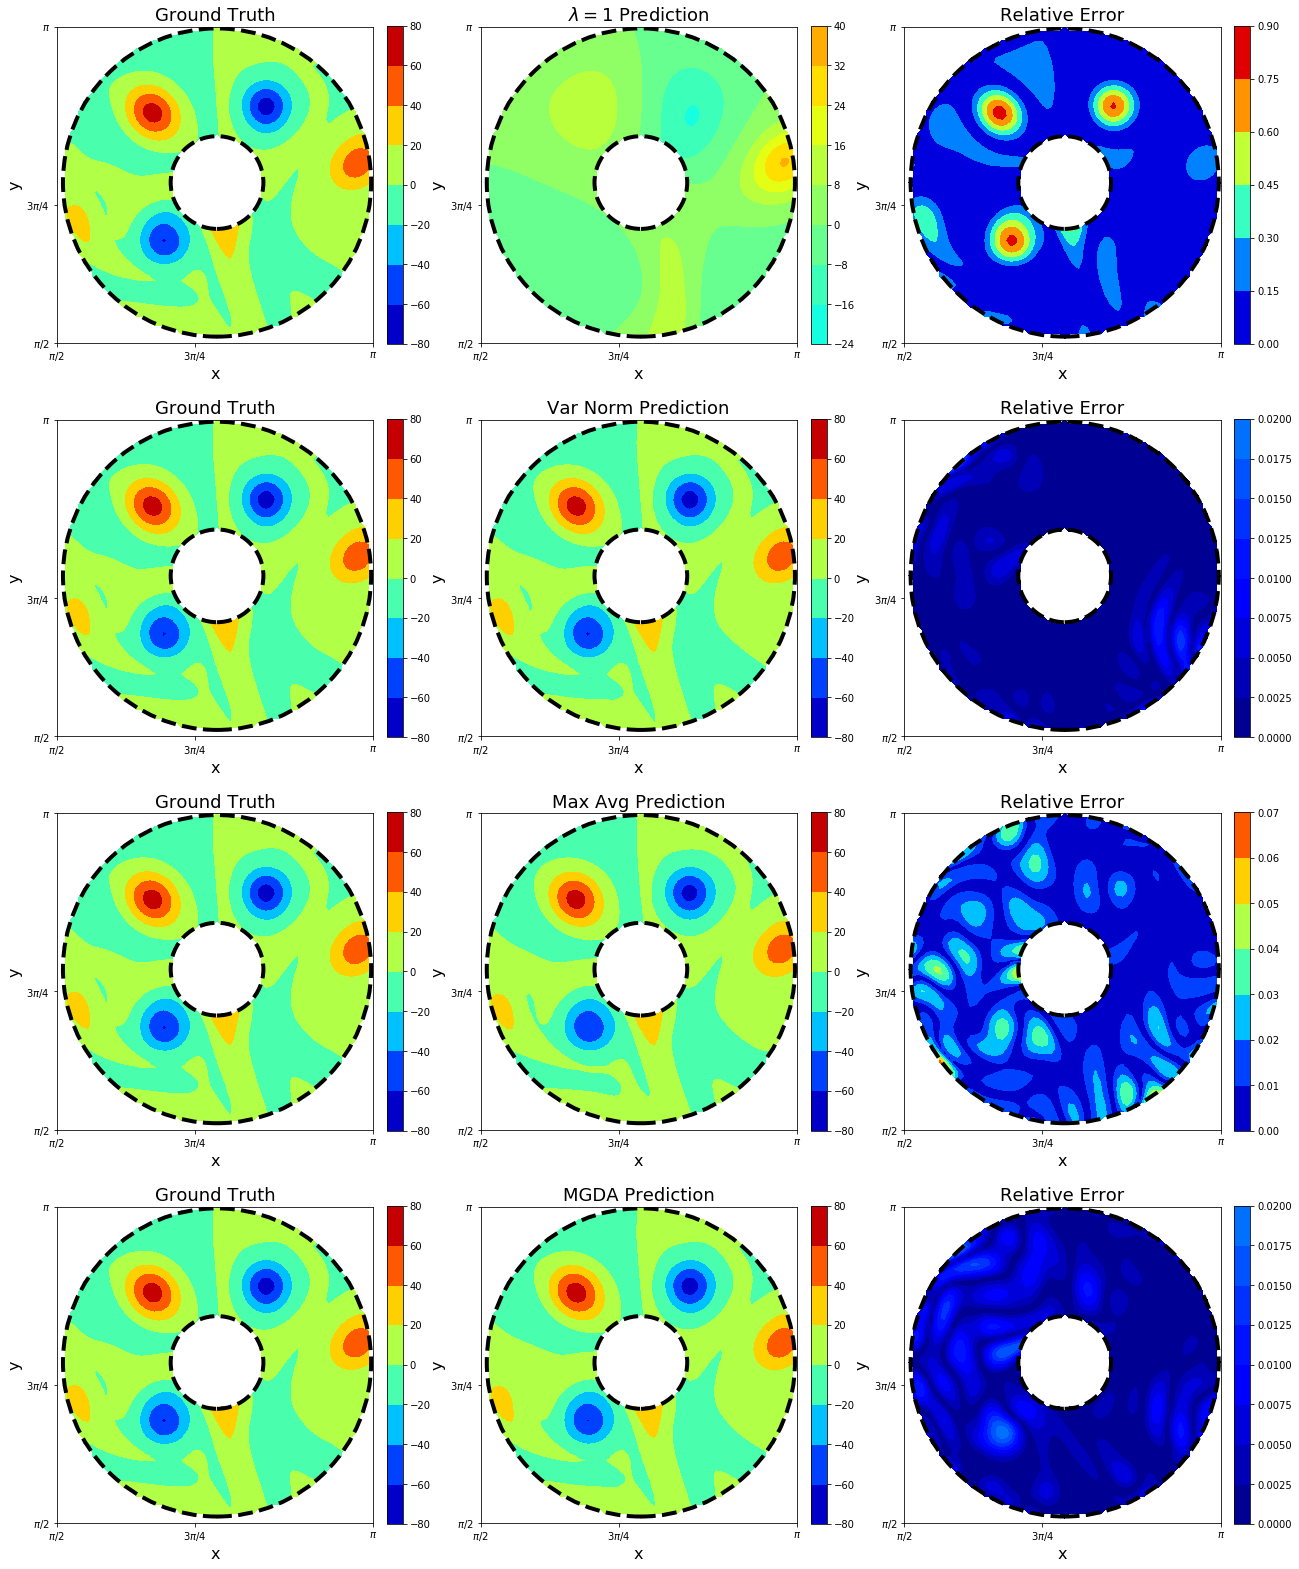

In [11]:
nl=0.0; tol=1e-6; app="_surya_bc_nown_circle"

mymap = "jet"
vmax = 0.08

label = [r"$\lambda=1$", "Var Norm", "Max Avg", "MGDA"]

t_ = 45
fig, axs = plt.subplots(4,3,figsize=(18,22))
for k,i in enumerate([4,6,5,3]):
    print(k,i)
    method = i
    
    uh, vh, wh, mask = pred_solution()
    
    whm = np.copy(wh)
    wm  = np.copy(w)

    whm[:, ~mask] = np.nan
    wm[:, ~mask] = np.nan
        
    im1 = axs[k,0].contourf(dom_x,dom_y,wm[t_,:,:], cmap=mymap, vmin=-80, vmax=80)
    im2 = axs[k,1].contourf(dom_x,dom_y,whm[t_,:,:], cmap=mymap, vmin=-80, vmax=80)
    
    if i == 4:
        im3 = axs[k,2].contourf(dom_x,dom_y,np.abs(whm[t_,:,:]-wm[t_,:,:])/np.max(np.abs(w[t_,mask])), cmap=mymap, vmin=0.0, vmax=0.9)
    else:
        im3 = axs[k,2].contourf(dom_x,dom_y,np.abs(whm[t_,:,:]-wm[t_,:,:])/np.max(np.abs(w[t_,mask])), cmap=mymap, vmin=0.0, vmax=vmax)
    
    fig.colorbar(im1, ax=axs[k,0], fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=axs[k,1], fraction=0.046, pad=0.04)
    fig.colorbar(im3, ax=axs[k,2], fraction=0.046, pad=0.04)
    
    for j in range(3):
        axs[k, j].set_xticks([x[0],x[31],x[-1]])
        axs[k, j].set_xticklabels([r"$\pi/2$", r"$3\pi/4$", r"$\pi$"])
        axs[k, j].set_yticks([x[0],x[31],x[-1]])
        axs[k, j].set_yticklabels([r"$\pi/2$", r"$3\pi/4$", r"$\pi$"])
        axs[k, j].set_ylabel("y", fontsize=16)
        axs[k, j].set_xlabel("x", fontsize=16)
        
        center = dom_x[int(len(dom_x)/2)]
        r1     = (dom_x[int(len(dom_x)/2)+10]-dom_x[int(len(dom_x)/2)-10])/2+1e-2
        r2     = (dom_x[int(len(dom_x)/2)+35]-dom_x[int(len(dom_x)/2)-35])/2-1e-2
        
        circ1 = plt.Circle((center,center), r1, fill=False, linewidth=4, linestyle="dashed")
        circ2 = plt.Circle((center,center), r2, fill=False, linewidth=4, linestyle="dashed")
        
        axs[k, j].add_artist(circ1)
        axs[k, j].add_artist(circ2)
        
        axs[k, j].set_aspect(1)
    
    axs[k,0].set_title("Ground Truth", fontsize=18)
    axs[k,1].set_title(label[k] + " Prediction", fontsize=18)
    axs[k,2].set_title("Relative Error", fontsize=18)
        
plt.tight_layout()
#plt.savefig("img/solve_vv_vorticity_circle_t465.eps")

# Square

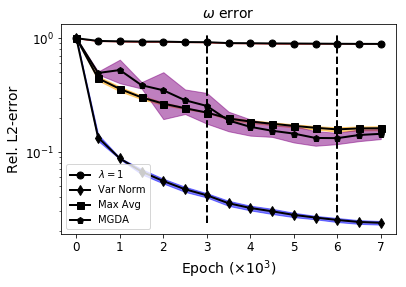

In [6]:
errs = []
for i,seed in enumerate(range(1,4)):
    _errs = []
    for j,m in enumerate([4,6,5,3]):
        d = None
        din = sio.loadmat("evals/init_err_square.mat")
        if m == 3:
            d = sio.loadmat("evals/solve_vv/eval_s{}_l7_nl0.0_dms256_meth{}_eps1e-07_surya_bc_nown_upt".format(seed,m))
        else:
            d = sio.loadmat("evals/solve_vv/eval_s{}_l7_nl0.0_dms256_meth{}_surya_bc_nown".format(seed,m))
                
        et = d["train_w"][0]
        if len(et)==71:
            _errs.append(et[:][::5])
        else:
            _errs.append(np.insert(et[4:][::5], 0, din["err"][j][i]))
    errs.append(_errs)

mean = np.mean(errs, 0)
std  = np.std(errs, 0) 

ticks = ["-o", "-d", "-s", "-p", "-v", "-+"]
#label = ["STD", "Reg. STD", "Max Avg", "Optimal 1e-6", "Optimal 1e-8", "Vanilla"]
label = [r"$\lambda=1$", "Var Norm", "Max Avg", "MGDA"]
colors = ["red", "blue", "orange", "purple"]

plt.plot(np.arange(0.0,7.1,0.5),  mean[0].T, ticks[0], label=label[0], color="black", linewidth=2, markersize=7)
plt.plot(np.arange(0.0,7.1,0.5),  mean[1].T, ticks[1], label=label[1], color="black", linewidth=2, markersize=7)
plt.plot(np.arange(0.0,7.1,0.5),  mean[2].T, ticks[2], label=label[2], color="black", linewidth=2, markersize=7)
plt.plot(np.arange(0.0,7.1,0.5), mean[3].T, ticks[3], label=label[3], color="black", linewidth=2, markersize=7)

plt.fill_between(np.arange(0.0,7.1,0.5), mean[0]-std[0], mean[0]+std[0], color=colors[0], alpha=0.5)
plt.fill_between(np.arange(0.0,7.1,0.5), mean[1]-std[1], mean[1]+std[1], color=colors[1], alpha=0.5)
plt.fill_between(np.arange(0.0,7.1,0.5), mean[2]-std[2], mean[2]+std[2], color=colors[2], alpha=0.5)
plt.fill_between(np.arange(0.0,7.1,0.5), mean[3]-std[3], mean[3]+std[3], color=colors[3], alpha=0.5)

plt.vlines(3, np.min(mean), np.max(mean)+0.1, color="black", linestyle="dashed", linewidth=2)
plt.vlines(6, np.min(mean), np.max(mean)+0.1, color="black", linestyle="dashed", linewidth=2)
    
plt.title(r"$\omega$ error", fontsize=14)
plt.ylabel("Rel. L2-error", fontsize=14)
plt.xlabel(r"Epoch ($\times 10^3$)", fontsize=14)
plt.yscale("log")
plt.legend()

plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("/projects/ppm/sturm/images/solve_vv_error_evolution_squared_seeded.eps")